In [0]:
import os
import torch
import matplotlib.pyplot as plt
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Data Loading and Model Definition

In [0]:
#%% Define paths and create datasets

data_root_dir = 'datasets'

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean,0.0,1.0)

class RandomOcclusion(object):
    def __init__(self, prob=0.5):
        self.prob = prob
    def __call__(self, tensor):
        mask=torch.FloatTensor(tensor.size()).uniform_() > self.prob
        return tensor * mask


train_dataset_original = MNIST(data_root_dir, train=True,  download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset_original  = MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_dataset_noise = MNIST(data_root_dir, train=True,  download=True, transform=transforms.Compose([transforms.ToTensor(),AddGaussianNoise(0.0, 0.3)]))
test_dataset_noise  = MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),AddGaussianNoise(0.0, 0.3)]))
train_dataset_more_noise = MNIST(data_root_dir, train=True,  download=True, transform=transforms.Compose([transforms.ToTensor(),AddGaussianNoise(0.0, 0.5)]))
test_dataset_more_noise  = MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),AddGaussianNoise(0.0, 0.5)]))
train_dataset_occlusion = MNIST(data_root_dir, train=True,  download=True, transform=transforms.Compose([transforms.ToTensor(),RandomOcclusion(0.5)]))
test_dataset_occlusion  = MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),RandomOcclusion(0.5)]))
compar=[train_dataset_original[0],train_dataset_noise[0],train_dataset_more_noise[0],train_dataset_occlusion[0]]

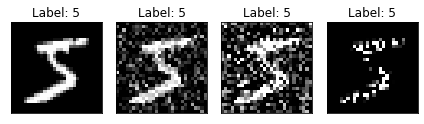

In [5]:
plt.close('all')
fig, axs = plt.subplots(1, 4)
for ii,ax in enumerate(axs.flatten()):
    img, label = compar[ii]
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig('Different_noises.png')
plt.show()

In [0]:
class Autoencoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )

        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Model Initialization and Training

In [0]:
dim_vector=[4,16]

for encoded_space_dim in dim_vector:

    ######################################################################
    ###################### CHANGE ENCODING DIMENSION #####################
    ######################################################################
    #encoded_space_dim =
    net = Autoencoder(encoded_space_dim=encoded_space_dim)
    num_epochs = 1000
    ######################################################################
    #train_dataset=train_dataset_original
    #test_dataset=test_dataset_original
    #out_dir=str(encoded_space_dim)+'_features/'
    #train_dataset=train_dataset_noise
    #test_dataset=test_dataset_noise
    #out_dir=+str(encoded_space_dim)+'_features_noise/'
    train_dataset=train_dataset_more_noise
    test_dataset=test_dataset_more_noise
    out_dir=str(encoded_space_dim)+'_features_more_noise/'
    ######################################################################
    out_path=Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    with open(out_dir + 'loss.txt', 'w+') as f:
        f.write("\tTRAINING\t\tVALIDATION\n")

    ### Define dataloader
    b_s=512
    train_dataloader = DataLoader(train_dataset, batch_size=b_s, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=b_s, shuffle=False)

    ### Define a loss function
    loss_fn = torch.nn.MSELoss()

    ######################################################################
    ######################### CHANGE LEARNING RATE #######################
    ######################################################################
    ### Define an optimizer
    lr = 1e-3 # Learning rate
    optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

    ### If cuda is available set the device to GPU
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    # Move all the network parameters to the selected device (if they are already on that device nothing happens)
    net.to(device)


    ### Training function
    def train_epoch(net, dataloader, loss_fn, optimizer):
        # Training
        net.train()
        train_loss_v=[]
        for sample_batch in dataloader:
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            output = net(image_batch)
            loss = loss_fn(output, image_batch)
            # Backward pass
            optim.zero_grad()
            loss.backward()
            optim.step()
            # Print loss
            train_loss=loss.data
            train_loss_v.append(train_loss.item())
            #print('\t partial train loss: %f' % (train_loss_v[-1]))
            
        print('TRAINING   - loss: %f' % np.mean(train_loss_v))
        with open(out_dir + 'loss.txt', 'a') as f:
            f.write(str(np.mean(train_loss_v))+'\t')


    ### Testing function
    def test_epoch(net, dataloader, loss_fn, optimizer):
        # Validation
        net.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # No need to track the gradients
            conc_out = torch.Tensor().float()
            conc_label = torch.Tensor().float()
            for sample_batch in dataloader:
                # Extract data and move tensors to the selected device
                image_batch = sample_batch[0].to(device)
                # Forward pass
                out = net(image_batch)
                # Concatenate with previous outputs
                conc_out = torch.cat([conc_out, out.cpu()])
                conc_label = torch.cat([conc_label, image_batch.cpu()]) 
            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)
        return val_loss.data


    ### Training cycle
    training = True
    if training:
        valid_loss_vec= []
        max_stagnation = 5
        best_val_loss = None
        best_val_epoch = None
        for epoch in range(num_epochs):
            print('EPOCH %d/%d' % (epoch + 1, num_epochs))
            ### Training
            with open(out_dir + 'loss.txt', 'a') as f:
                f.write(str(epoch+1)+'\t')
            train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim) 
            ### Validation
            val_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim) 
            # Print Validationloss
            print('VALIDATION - loss: %f' % val_loss)
            valid_loss_vec.append(val_loss.item())
            with open(out_dir + 'loss.txt', 'a') as f:
                #f.write('VALIDATION EPOCH '+str(epoch+1)+'\n')
                f.write(str(val_loss.item())+'\n')

            ### Plot progress
            img = test_dataset[0][0].unsqueeze(0).to(device)
            net.eval()
            with torch.no_grad():
                rec_img  = net(img)
            fig, axs = plt.subplots(1, 2, figsize=(12,6))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            # Save figures
            plt.savefig(out_dir+'epoch_'+str(epoch+1)+'.png')
            plt.show()
            plt.close()

            # Save network parameters
            torch.save(net.state_dict(), out_dir+'net_params.pth')
            if best_val_loss is None or valid_loss_vec[-1] < best_val_loss:
                best_val_loss = valid_loss_vec[-1]
                best_val_epoch = epoch
            if best_val_epoch < epoch - max_stagnation:
                break
    else:
        print("No new training")

In [0]:
import os
import torch
import matplotlib.pyplot as plt
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Data Loading and Model Definition

In [0]:
#%% Define paths and create datasets

data_root_dir = 'datasets'

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean,0.0,1.0)

class RandomOcclusion(object):
    def __init__(self, prob=0.5):
        self.prob = prob
    def __call__(self, tensor):
        mask=torch.FloatTensor(tensor.size()).uniform_() > self.prob
        return tensor * mask

In [0]:
class Autoencoder(nn.Module):

    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )

        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Network Analysis

100%|██████████| 1000/1000 [00:01<00:00, 733.16it/s]


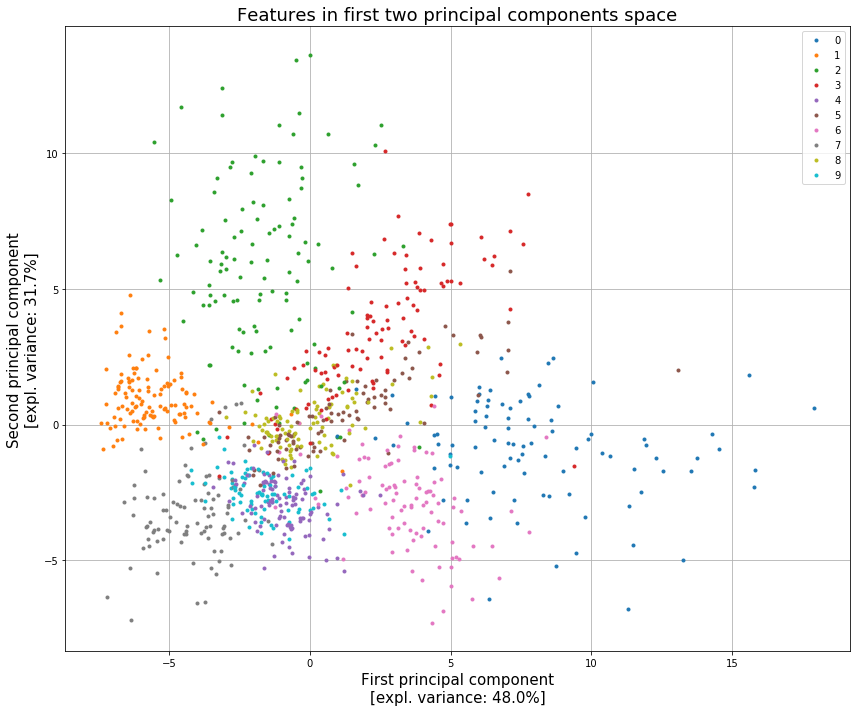

In [0]:
encoded_space_dim = 4
save_dir='scatter/pca_4_more_noise.png'
######################################################################
#test_dataset=MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
#out_dir=str(encoded_space_dim)+'_features/'
#test_dataset=MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),AddGaussianNoise(0.0, 0.3)]))
#out_dir=+str(encoded_space_dim)+'_features_noise/'
test_dataset=MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),AddGaussianNoise(0.0, 0.5)]))
out_dir=str(encoded_space_dim)+'_features_more_noise/'
######################################################################
net = Autoencoder(encoded_space_dim=encoded_space_dim)
device = torch.device("cpu") #THIS PART IS FASTER ON CPU
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
net.load_state_dict(torch.load(out_dir+'net_params.pth', map_location=device))
net.to(device)

### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    net.eval()
    with torch.no_grad():
        encoded_img  = net.encode(img)
    # Append to list
    encoded_samples.append((encoded_img.flatten().cpu().numpy(), label))
    

### Visualize encoded space
color_map = {
        0: '#1f77b4',
        1: '#ff7f0e',
        2: '#2ca02c',
        3: '#d62728',
        4: '#9467bd',
        5: '#8c564b',
        6: '#e377c2',
        7: '#7f7f7f',
        8: '#bcbd22',
        9: '#17becf'
        }


    
# Plot just 1k points
encoded_samples_reduced = random.sample(encoded_samples, 1000)
mat1=np.array([np.array(jj) for jj in encoded_samples_reduced])
mat2=mat1[:,0].tolist()
labels=mat1[:,1].tolist()
mat3=np.vstack(mat2)
pca_function=PCA(n_components=2)
mat4=pca_function.fit_transform(mat3)
mat5=mat4.tolist()
plt.figure(figsize=(12,10))

for enc_sample, label in tqdm(zip(mat5,labels),total=len(labels)):
    plt.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
plt.title('Features in first two principal components space', fontsize = 18)
plt.xlabel('First principal component\n[expl. variance: ' 
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[0]*100)) + '%]', fontsize = 15)
plt.ylabel('Second principal component\n[expl. variance: '
              + str("{:.1f}".format(pca_function.explained_variance_ratio_[1]*100)) + '%]', fontsize = 15)
plt.grid(True)
plt.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys())
plt.tight_layout()
plt.savefig(save_dir)
plt.show()

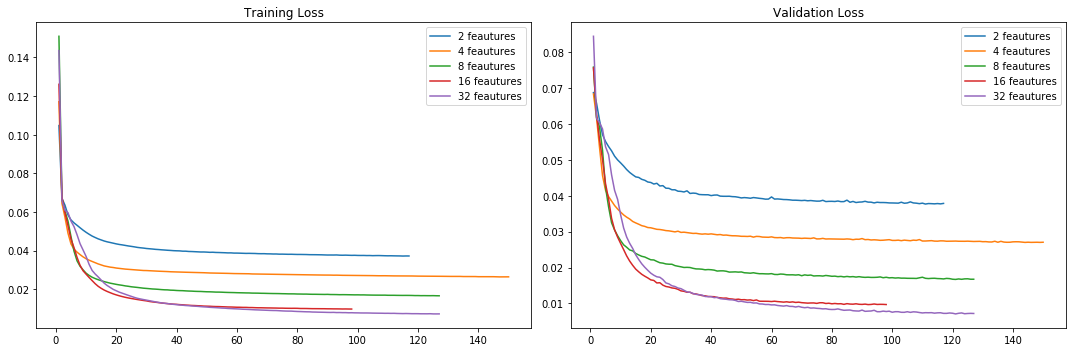

,Features,Epochs,Validation Loss
0,2,117,0.037863
1,4,150,0.027053
2,8,127,0.016753
3,16,98,0.009706
4,32,127,0.007214


In [0]:
out_dir2='2_features/'
df2=pd.read_csv(out_dir2+'loss.txt', delim_whitespace=True)
out_dir4='4_features/'
df4=pd.read_csv(out_dir4+'loss.txt', delim_whitespace=True)
out_dir8='8_features/'
df8=pd.read_csv(out_dir8+'loss.txt', delim_whitespace=True)
out_dir16='16_features/'
df16=pd.read_csv(out_dir16+'loss.txt', delim_whitespace=True)
out_dir32='32_features/'
df32=pd.read_csv(out_dir32+'loss.txt', delim_whitespace=True)
figure = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(df2['TRAINING'], label='2 feautures')
plt.plot(df4['TRAINING'], label='4 feautures')
plt.plot(df8['TRAINING'], label='8 feautures')
plt.plot(df16['TRAINING'], label='16 feautures')
plt.plot(df32['TRAINING'], label='32 feautures')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Validation Loss')
plt.plot(df2['VALIDATION'], label='2 feautures')
plt.plot(df4['VALIDATION'], label='4 feautures')
plt.plot(df8['VALIDATION'], label='8 feautures')
plt.plot(df16['VALIDATION'], label='16 feautures')
plt.plot(df32['VALIDATION'], label='32 feautures')
plt.legend()
plt.tight_layout()
plt.savefig('Comparison_no_noise.png')
plt.show()
lll=[]
lll.append([2,len(df2),df2['VALIDATION'].iloc[-1]])
lll.append([4,len(df4),df4['VALIDATION'].iloc[-1]])
lll.append([8,len(df8),df8['VALIDATION'].iloc[-1]])
lll.append([16,len(df16),df16['VALIDATION'].iloc[-1]])
lll.append([32,len(df32),df32['VALIDATION'].iloc[-1]])
pd.DataFrame(lll, columns = ['Features', 'Epochs','Validation Loss'])

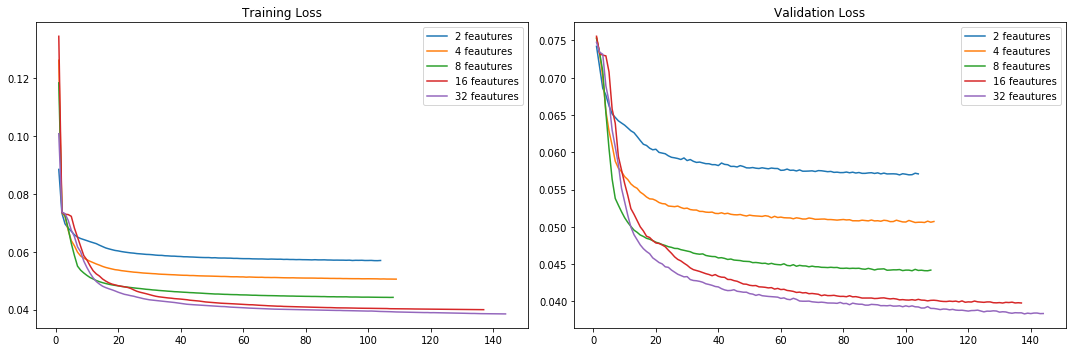

,Features,Epochs,Validation Loss
0,2,104,0.057106
1,4,109,0.050721
2,8,108,0.044203
3,16,137,0.039792
4,32,144,0.038378


In [0]:
out_dir2='2_features_noise/'
df2=pd.read_csv(out_dir2+'loss.txt', delim_whitespace=True)
out_dir4='4_features_noise/'
df4=pd.read_csv(out_dir4+'loss.txt', delim_whitespace=True)
out_dir8='8_features_noise/'
df8=pd.read_csv(out_dir8+'loss.txt', delim_whitespace=True)
out_dir16='16_features_noise/'
df16=pd.read_csv(out_dir16+'loss.txt', delim_whitespace=True)
out_dir32='32_features_noise/'
df32=pd.read_csv(out_dir32+'loss.txt', delim_whitespace=True)
figure = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(df2['TRAINING'], label='2 feautures')
plt.plot(df4['TRAINING'], label='4 feautures')
plt.plot(df8['TRAINING'], label='8 feautures')
plt.plot(df16['TRAINING'], label='16 feautures')
plt.plot(df32['TRAINING'], label='32 feautures')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Validation Loss')
plt.plot(df2['VALIDATION'], label='2 feautures')
plt.plot(df4['VALIDATION'], label='4 feautures')
plt.plot(df8['VALIDATION'], label='8 feautures')
plt.plot(df16['VALIDATION'], label='16 feautures')
plt.plot(df32['VALIDATION'], label='32 feautures')
plt.legend()
plt.tight_layout()
plt.savefig('Comparison_with_noise.png')
plt.show()
lll=[]
lll.append([2,len(df2),df2['VALIDATION'].iloc[-1]])
lll.append([4,len(df4),df4['VALIDATION'].iloc[-1]])
lll.append([8,len(df8),df8['VALIDATION'].iloc[-1]])
lll.append([16,len(df16),df16['VALIDATION'].iloc[-1]])
lll.append([32,len(df32),df32['VALIDATION'].iloc[-1]])
pd.DataFrame(lll, columns = ['Features', 'Epochs','Validation Loss'])

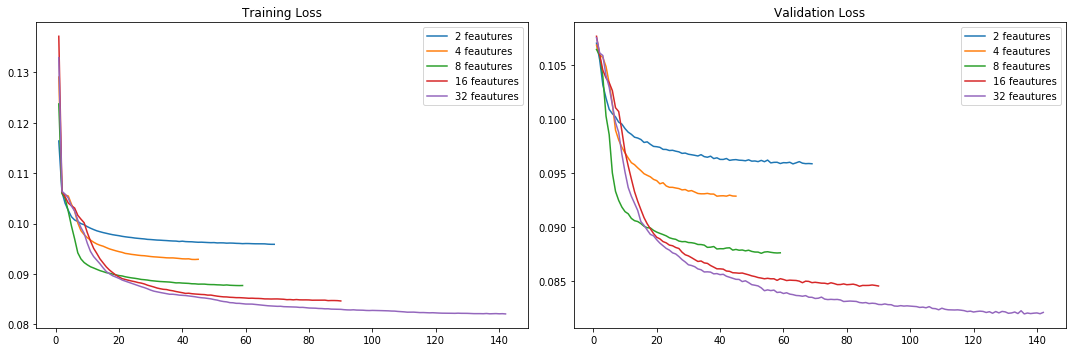

,Features,Epochs,Validation Loss
0,2,69,0.095856
1,4,45,0.092858
2,8,59,0.087611
3,16,90,0.084539
4,32,142,0.082094


In [0]:
out_dir2='2_features_more_noise/'
df2=pd.read_csv(out_dir2+'loss.txt', delim_whitespace=True)
out_dir4='4_features_more_noise/'
df4=pd.read_csv(out_dir4+'loss.txt', delim_whitespace=True)
out_dir8='8_features_more_noise/'
df8=pd.read_csv(out_dir8+'loss.txt', delim_whitespace=True)
out_dir16='16_features_more_noise/'
df16=pd.read_csv(out_dir16+'loss.txt', delim_whitespace=True)
out_dir32='32_features_more_noise/'
df32=pd.read_csv(out_dir32+'loss.txt', delim_whitespace=True)
figure = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(df2['TRAINING'], label='2 feautures')
plt.plot(df4['TRAINING'], label='4 feautures')
plt.plot(df8['TRAINING'], label='8 feautures')
plt.plot(df16['TRAINING'], label='16 feautures')
plt.plot(df32['TRAINING'], label='32 feautures')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Validation Loss')
plt.plot(df2['VALIDATION'], label='2 feautures')
plt.plot(df4['VALIDATION'], label='4 feautures')
plt.plot(df8['VALIDATION'], label='8 feautures')
plt.plot(df16['VALIDATION'], label='16 feautures')
plt.plot(df32['VALIDATION'], label='32 feautures')
plt.legend()
plt.tight_layout()
plt.savefig('Comparison_with_more_noise.png')
plt.show()
lll=[]
lll.append([2,len(df2),df2['VALIDATION'].iloc[-1]])
lll.append([4,len(df4),df4['VALIDATION'].iloc[-1]])
lll.append([8,len(df8),df8['VALIDATION'].iloc[-1]])
lll.append([16,len(df16),df16['VALIDATION'].iloc[-1]])
lll.append([32,len(df32),df32['VALIDATION'].iloc[-1]])
pd.DataFrame(lll, columns = ['Features', 'Epochs','Validation Loss'])

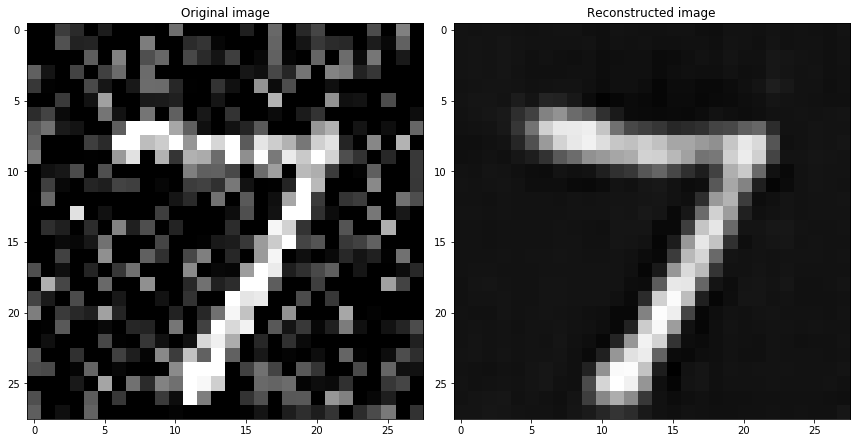

In [6]:
encoded_space_dim = 32
######################################################################
#out_dir=str(encoded_space_dim)+'_features/'
out_dir=str(encoded_space_dim)+'_features_noise/'
#out_dir=+str(encoded_space_dim)+'_features_more_noise/'
test_dataset = MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),AddGaussianNoise(0.0, 0.3)]))
#test_dataset = MNIST(data_root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),RandomOcclusion(0.5)]))
save_dir='comparison_'+str(encoded_space_dim)+'_features/gaussian_03_denoise.png'
######################################################################
net = Autoencoder(encoded_space_dim=encoded_space_dim)
device = torch.device("cpu") #THIS PART IS FASTER ON CPU
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
net.load_state_dict(torch.load(out_dir+'net_params.pth', map_location=device))
net.to(device)


### Plot progress
img = test_dataset[0][0].unsqueeze(0).to(device)
net.eval()
with torch.no_grad():
    rec_img  = net(img)
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Original image')
axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Reconstructed image')
plt.tight_layout()
# Save figures
plt.savefig(save_dir)
plt.show()